In [3]:
from asammdf import MDF
import easygui
import pandas as pd
import glob, os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic_2d 

datFiles = easygui.fileopenbox(msg='Select dat files', default='*.dat', multiple = True)
#get the folderpath of dat file
folderPath = os.path.dirname(datFiles[0])

def Averaging_df(x,y):
    RPM = [3400,3200,3000,2800,2600,2400,2200,2000,1800,1600,1400,1200]
    mean_ = []
    for i in RPM:
        df_i = x[(x['cps_n_engine'] > i-50) & (x['cps_n_engine'] < i+50)]
        a = df_i[y].mean()
        mean_.append(a)
    mean_dict = {'Engine Speed':RPM,y:mean_}
    df_mean_ = pd.DataFrame(mean_dict)
    df_mean_.set_index(df_mean_['Engine Speed'])
    # print(df_mean_)
    return df_mean_



def graph_(X,Y):
    RPM = [3400,3200,3000,2800,2600,2400,2200,2000,1800,1600,1400,1200]
    graph_ = X.plot(x = 'Engine Speed', y = Y,figsize=(10, 6), rot=90,xticks= RPM,kind = 'line',grid=True)
    return graph_

#def read_df():
# dfs = {}
for datFile in datFiles:
    baseName = os.path.basename(datFile)[:-4]
    KS_filename = baseName + '.xlsx'
    KS_filepath = os.path.join(folderPath, KS_filename)
    xlsx_KS_file = pd.ExcelFile(KS_filepath)
    df_KS = xlsx_KS_file.parse('Sheet1')
    df_KS.drop(([0,1]),axis=0,inplace=True)
    sl_no = list(range(0,12))
    df_KS['sl_no'] = sl_no
    df_KS.set_index(df_KS['sl_no'])
    
    mdf = MDF(datFile)
    allSignals = list(mdf.channels_db.keys())
    measuredSignals = []
    #remove signals with CPP in it
    for signal in allSignals:
        if not(("CCP" in signal) or ("_sword" in signal) or "$" in signal):
            measuredSignals.append(signal)
        #creating an empty list of important signals
    impSignals = ['cps_n_engine', 'egr_b_operate_valve', 
                     'egr_T_exhaust_temperature', 'egr_T_oil_temperature',
                     'egr_T_limiting_temp_low', 'egr_T_limiting_temp_high',
                     'egr_P_exhaustp']
    df = mdf.to_dataframe(
            channels=impSignals,
            raster= 'egr_b_operate_valve',
            time_from_zero=True,
            empty_channels="zeros",
    #              keep_arrays=False,
            use_display_names=True,
            time_as_date=True,
            reduce_memory_usage=True,
            raw=False,
            ignore_value2text_conversions=False)
    #remove \CCP from column names of dataframe
    df.columns = [col.split('\\')[0] for col in df.columns]
    #resampling the data to 1 second
    df = df.resample('S').mean()
        
    n_i = list(range(1,len(df['egr_b_operate_valve'])+1))
    df['Sl.no'] = n_i
    df.set_index('Sl.no',inplace=True)
    mdf.close()
     
    
    columnOrderExcel = impSignals
    excelFile = baseName + "WOT.xlsx"
    #df_pressure = pd.DataFrame.append(df)
    graphFolderPath = os.path.join(folderPath, baseName)
    if not os.path.exists(graphFolderPath):
        os.mkdir(graphFolderPath)
    
    excelFilePath = os.path.join(graphFolderPath, excelFile)
    # df.to_excel(excelFilePath, columns = columnOrderExcel)
    df_Exh_temp = Averaging_df(df,'egr_T_exhaust_temperature')
    df_Oil_temp = Averaging_df(df,'egr_T_oil_temperature')    
    df_Exh_press = Averaging_df(df,'egr_P_exhaustp') 

    df_Average = df_Exh_temp.join((df_Oil_temp['egr_T_oil_temperature'],df_Exh_press['egr_P_exhaustp']))
   
    
    df_Average['Vehicle speed (km/h)'] = df_KS['v_act_kmh'].values
    df_Average['Power (kW)'] = df_KS['Power_vehicle'].values
    df_Average['Fuel flow (kg/h)'] = df_KS['act_fr_flow'].values
    df_Average['Tractive Force (Nm)'] = df_KS['f_vehicle_engine'].values
    
    df_Average.to_excel(excelFilePath)
    
    df_graph = df_Average
    df_graph.set_index(df_graph['Engine Speed'])  

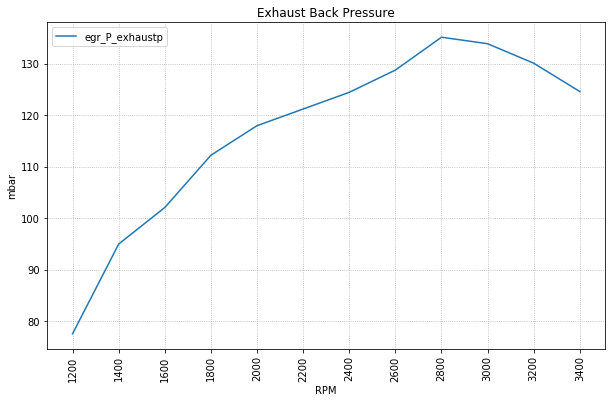

In [4]:
    Exhaust_pressure = graph_(df_Average,'egr_P_exhaustp')
    plt.grid(linestyle='dotted')
    plt.xlabel('RPM')
    plt.ylabel('mbar')
    plt.title('Exhaust Back Pressure')
    plt.show()

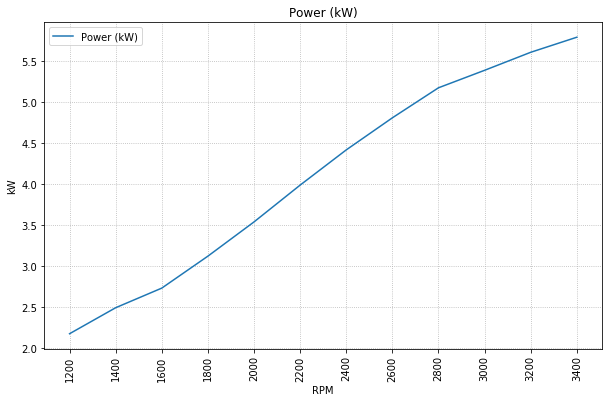

In [5]:
    Power = graph_(df_Average,'Power (kW)')
    plt.grid(linestyle='dotted')
    plt.xlabel('RPM')
    plt.ylabel('kW')
    plt.title('Power (kW)')
    plt.show()

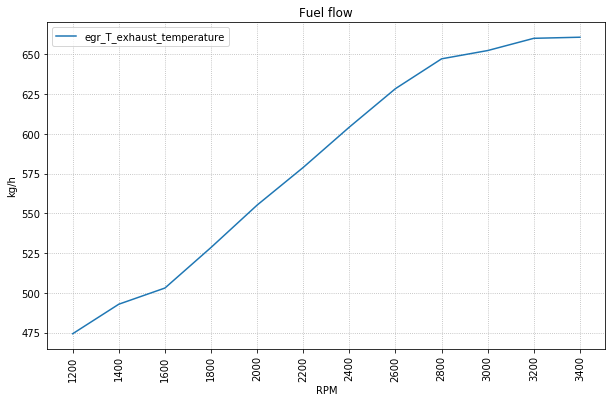

In [6]:
    Fuel_flow = graph_(df_Average,'egr_T_exhaust_temperature')
    plt.grid(linestyle='dotted')
    plt.xlabel('RPM')
    plt.ylabel('kg/h')
    plt.title('Fuel flow')
    plt.show()

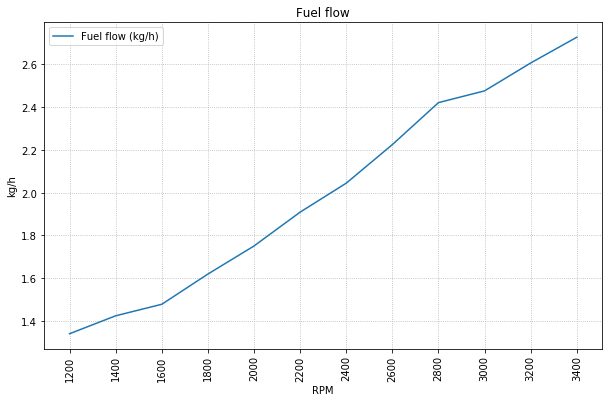

In [7]:
    Fuel_flow = graph_(df_Average,'Fuel flow (kg/h)')
    plt.grid(linestyle='dotted')
    plt.xlabel('RPM')
    plt.ylabel('kg/h')
    plt.title('Fuel flow')
    plt.show()